# Predicción del Engagement en Puntos de Interés Turísticos

## 0. Introducción

Este proyecto tiene como objetivo desarrollar un modelo de **Deep Learning multimodal** capaz de predecir si un punto de interés turístico (POI) generará un nivel **alto o bajo de engagement** entre los usuarios. El término *engagement* se refiere al nivel de interacción que los usuarios tienen con los POIs dentro de una plataforma digital, expresado mediante métricas como visitas, likes, bookmarks o dislikes.

Los datos utilizados en este estudio provienen de la plataforma Artgonuts, garantizando así su relevancia y aplicabilidad en contextos reales
del sector turístico. Las imágenes empleadas han sido específicamente procesadas para los fines de esta práctica, siendo sus versiones originales en alta
resolución procedentes de diversas fuentes, incluyendo el portal de datos
abiertos de la Comunidad de Madrid.

El modelo combinará información de **dos fuentes complementarias**:

- **Características visuales** extraídas de imágenes mediante redes neuronales convolucionales (CNN).
- **Metadatos estructurados** asociados a cada POI (como ubicación, categoría, etiquetas, etc.), procesados mediante redes densas (DNN).

La combinación de ambas fuentes de información en un único modelo permite capturar tanto el impacto visual como el contexto informativo, ofreciendo una capacidad predictiva superior a la de modelos unimodales.

## 1. Descripción del Dataset

El dataset proporcionado contiene información detallada sobre distintos puntos de interés turísticos, y está compuesto por dos partes principales:

- **Imágenes**: Cada POI cuenta con una imagen principal representativa, cuya ruta está especificada en la columna `main_image_path`.

- **Metadatos**: Datos estructurados asociados a cada POI, entre los que se incluyen:
  - Identificador único (`id`)
  - Nombre (`name`)
  - Descripción (`shortDescription`)
  - Ubicación geográfica (`locationLat`, `locationLon`, `distrito`, `barrio`)
  - Categorías (`categories`)
  - Etiquetas (`tags`)
  - Nivel de popularidad (`tier`)
  - Puntos de experiencia (`xps`)
  - Métricas de interacción: `visits`, `likes`, `dislikes`, `bookmarks`

El dataset se encuentra en formato CSV y está vinculado con una carpeta de imágenes.
En este proyecto, trabajaremos con una **variable objetivo construida a partir de las métricas de interacción**, para definir el nivel de engagement de forma binaria (alto vs bajo), y construiremos un modelo que integre imágenes y metadatos para predecir esta variable.


## 2. Estructura general del notebook

El desarrollo del proyecto se organiza en las siguientes etapas, siguiendo buenas prácticas de aprendizaje automático y deep learning:

3. **Carga inicial de datos**  
   Lectura del dataset de metadatos, inspección rápida y eliminación de columnas irrelevantes.

4. **Definición de la variable objetivo (`engagement_target`)**  
   Creación de una métrica sintética de engagement a partir de las interacciones (`visits`, `likes`, `dislikes`, `bookmarks`) y su transformación en una etiqueta binaria: engagement alto o bajo.

5. **División en conjuntos de entrenamiento, validación y prueba**  
   Separación estratificada del dataset en tres subconjuntos. A partir de este punto, todas las decisiones de análisis, normalización y codificación se realizarán exclusivamente sobre el conjunto de entrenamiento para evitar *data leakage*.

6. **Análisis exploratorio y preprocesamiento**  
   - Análisis de valores nulos y distribución de variables.  
   - Imputación, normalización y codificación de variables categóricas.  
   - Preparación final de los datos estructurados para alimentar la red neuronal.

7. **Preparación de imágenes**  
   Carga, redimensionamiento y normalización de imágenes asociadas a cada POI. Se define un `Dataset` que incluye metadatos e imágenes.

8. **Construcción del modelo multimodal**  
   Implementación de una arquitectura que combine:
   - Una red convolucional (CNN) para extraer features visuales.
   - Una red densa (DNN) para procesar metadatos.
   - Una capa de fusión que concatena ambas salidas y alimenta al clasificador final.

9. **Entrenamiento del modelo**  
   Entrenamiento con validación, utilizando Binary Cross Entropy como función de pérdida y estrategias de regularización como Dropout y Early Stopping.

10. **Evaluación del modelo**  
   Evaluación del rendimiento en el conjunto de validación utilizando métricas como Accuracy, Precision, Recall, F1-score y matriz de confusión.

11. **Conclusiones**  
   Reflexión sobre los resultados obtenidos, principales aprendizajes y posibles líneas de mejora futura.

12. **Reproducibilidad**  
    Se documenta el entorno utilizado (`requirements.txt`) y se asegura la fijación de semillas aleatorias para permitir la replicabilidad del experimento.


## 3. Carga inicial de datos

En esta sección se realiza la carga y verificación inicial del dataset de metadatos turísticos proporcionado en formato CSV. Además, se detectan y corrigen errores de formato comunes en archivos CSV mal generados, como saltos de línea dentro de campos no entrecomillados.

> ⚠️ **Aún no se realiza preprocesamiento estadístico, análisis exploratorio ni imputación de datos.** Estas acciones se llevarán a cabo únicamente sobre el conjunto de entrenamiento luego de la partición del dataset, para evitar *data leakage*.

### Acciones realizadas:
- Lectura inicial del archivo `poi_dataset.csv`.
- Verificación del número de filas, columnas y estructura general.
- Identificación de líneas mal formateadas con menos delimitadores de los esperados.
- Reparación automática del archivo, reconstruyendo registros partidos por saltos de línea dentro de campos de texto (e.g., descripciones largas).
- Generación de una copia limpia y un respaldo del archivo original (`poi_dataset_clean.csv` y `poi_dataset_backup.csv` respectivamente).
- Nueva carga del dataset limpio para continuar con el análisis.



In [1]:
from google.colab import files
uploaded = files.upload()


Saving data_main.zip to data_main (1).zip
Saving poi_dataset.csv to poi_dataset (1).csv


In [2]:
!unzip -q data_main.zip -d ./


replace ./data_main/293f979b-a3b4-49c1-9fca-29bcea8a9ce8/main.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [3]:
import pandas as pd
import random
import numpy as np
import torch

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 42
set_seed(seed)


# Cargar el dataset
df = pd.read_csv("poi_dataset.csv")


In [4]:
# Mostrar dimensiones del dataframe
print(f"Número de filas: {df.shape[0]}")
print(f"Número de columnas: {df.shape[1]}")

# Ver columnas disponibles
print("\nColumnas disponibles:")
print(df.columns.tolist())

# Vista rápida de los primeros registros
df.head()

Número de filas: 1569
Número de columnas: 14

Columnas disponibles:
['id', 'name', 'shortDescription', 'categories', 'tier', 'locationLon', 'locationLat', 'tags', 'xps', 'Visits', 'Likes', 'Dislikes', 'Bookmarks', 'main_image_path']


,id,name,shortDescription,categories,tier,locationLon,locationLat,tags,xps,Visits,Likes,Dislikes,Bookmarks,main_image_path
0,4b36a3ed-3b28-4bc7-b975-1d48b586db03,Galería Fran Reus,La Galería Fran Reus es un espacio dedicado a ...,"['Escultura', 'Pintura']",1,2.642262,39.572694,[],500,10009,422,3582,78,data_main/4b36a3ed-3b28-4bc7-b975-1d48b586db03...
1,e32b3603-a94f-49df-8b31-92445a86377c,Convento de San Plácido,"El Convento de San Plácido en Madrid, fundado ...","['Patrimonio', 'Historia']",1,-3.704467,40.423037,[],500,10010,7743,96,2786,data_main/e32b3603-a94f-49df-8b31-92445a86377c...
2,0123a69b-13ac-4b65-a5d5-71a95560cff5,Instituto Geológico y Minero de España,"El Instituto Geológico y Minero de España, sit...","['Ciencia', 'Patrimonio']",2,-3.699694,40.442045,[],250,10015,3154,874,595,data_main/0123a69b-13ac-4b65-a5d5-71a95560cff5...
3,390d7d9e-e972-451c-b5e4-f494af15e788,Margarita Gil Roësset,"Margarita Gil Roësset, escultora y poetisa esp...",['Cultura'],1,-3.691228,40.427256,[],500,10011,8559,79,2358,data_main/390d7d9e-e972-451c-b5e4-f494af15e788...
4,023fc1bf-a1cd-4b9f-af78-48792ab1a294,Museo del Traje. Centro de Investigación del P...,"El Museo del Traje de Madrid, fundado en 2004,...","['Patrimonio', 'Cultura']",1,-3.727822,40.439665,[],500,10020,915,2896,143,data_main/023fc1bf-a1cd-4b9f-af78-48792ab1a294...


In [5]:
# Detección de registros mal tabulados
with open("poi_dataset.csv", encoding='utf-8') as f:
    for i, line in enumerate(f):
        if line.count(',') < 13:
            print(f"Línea sospechosa {i + 1}: {line}")


Línea sospechosa 84: d95361c3-d8a1-4c14-a620-add96fe61c73,ADEMA Escuela Universitaria,"Exposició Wasini Soul - Alumnes i professors del Grau 

Línea sospechosa 85: de Belles Arts d’ADEMA","['Pintura', 'Escultura']",2,2.656616190358899,39.60272108052334,[],250,10014,492,3144,50,data_main/d95361c3-d8a1-4c14-a620-add96fe61c73/main.jpg

Línea sospechosa 1560: 4de1c063-1671-4e66-aea2-c18dfc65d9d5,Páginas madrileñas. En casa de Lhardy,"TOMÁS MUÑOZ LUCENA

Línea sospechosa 1561: Páginas madrileñas. En casa de Lhardy

Línea sospechosa 1562: Blanco y Negro, núm. 264, 23 de mayo de 1896

Línea sospechosa 1563: Gouache y tinta sobre papel, 457 x 313 mm.",['Pintura'],1,-3.701388507604293,40.41662328914285,['Lhardy'],600,10004,727,2772,122,data_main/4de1c063-1671-4e66-aea2-c18dfc65d9d5/main.jpg

Línea sospechosa 1564: 4263cb1a-1d39-4c8c-83db-74b36c4c7eb7,La hora del «cine»,"FRANCISCO SANCHA

Línea sospechosa 1565: La hora del «cine»

Línea sospechosa 1566: ABC, núm. 10.141, 24 de noviembre de 1935


In [6]:
import shutil

# Hacer una copia de seguridad del archivo original
original_file = "poi_dataset.csv"
backup_file = "poi_dataset_backup.csv"
clean_file = "poi_dataset_clean.csv"

shutil.copyfile(original_file, backup_file)

# Procesar el archivo y reconstruir líneas válidas
EXPECTED_NUM_FIELDS = 14
EXPECTED_NUM_COMMAS = EXPECTED_NUM_FIELDS - 1

with open(original_file, 'r', encoding='utf-8') as f:
    lines = f.readlines()

clean_lines = []
buffer = ""

for line in lines:
    line = line.strip('\n')

    if not buffer:
        buffer = line
    else:
        buffer += " " + line  # Añade la línea rota

    # Contar comas para validar si la línea es completa
    if buffer.count(',') >= EXPECTED_NUM_COMMAS:
        clean_lines.append(buffer)
        buffer = ""

# Si queda algo en el buffer, también lo guardamos
if buffer:
    clean_lines.append(buffer)

# 3. Guardar archivo limpio
with open(clean_file, 'w', encoding='utf-8') as f:
    for cline in clean_lines:
        f.write(cline + '\n')

print(f"Archivo limpio guardado como: {clean_file}")
print(f"Total líneas válidas: {len(clean_lines)}")


Archivo limpio guardado como: poi_dataset_clean.csv
Total líneas válidas: 1570


In [7]:
import pandas as pd

# Leer el archivo limpio
df = pd.read_csv("poi_dataset_clean.csv")

# Ver las primeras filas
print(df.head())

# Verificar estructura general
print(f"\nFilas: {df.shape[0]}, Columnas: {df.shape[1]}")


                                     id  \
0  4b36a3ed-3b28-4bc7-b975-1d48b586db03   
1  e32b3603-a94f-49df-8b31-92445a86377c   
2  0123a69b-13ac-4b65-a5d5-71a95560cff5   
3  390d7d9e-e972-451c-b5e4-f494af15e788   
4  023fc1bf-a1cd-4b9f-af78-48792ab1a294   

                                                name  \
0                                  Galería Fran Reus   
1                            Convento de San Plácido   
2             Instituto Geológico y Minero de España   
3                              Margarita Gil Roësset   
4  Museo del Traje. Centro de Investigación del P...   

                                    shortDescription  \
0  La Galería Fran Reus es un espacio dedicado a ...   
1  El Convento de San Plácido en Madrid, fundado ...   
2  El Instituto Geológico y Minero de España, sit...   
3  Margarita Gil Roësset, escultora y poetisa esp...   
4  El Museo del Traje de Madrid, fundado en 2004,...   

                   categories  tier  locationLon  locationLat tags 

## 4. Definición de la variable objetivo

En esta sección se define la variable objetivo que será utilizada por el modelo de clasificación binaria. Para ello se construye una métrica sintética llamada `engagement_score`, la cual combina distintas señales de interacción del usuario con los puntos de interés (POIs) turísticos: visitas, likes, bookmarks y dislikes.

Posteriormente, esta métrica continua se transforma en una etiqueta binaria (`engagement_target`) indicando si el POI presenta un nivel de engagement alto (`1`) o bajo (`0`), con base en un umbral seleccionado sobre la distribución de scores.

El diseño de esta variable es clave para reflejar el comportamiento real de los usuarios y guiar correctamente el aprendizaje supervisado del modelo.


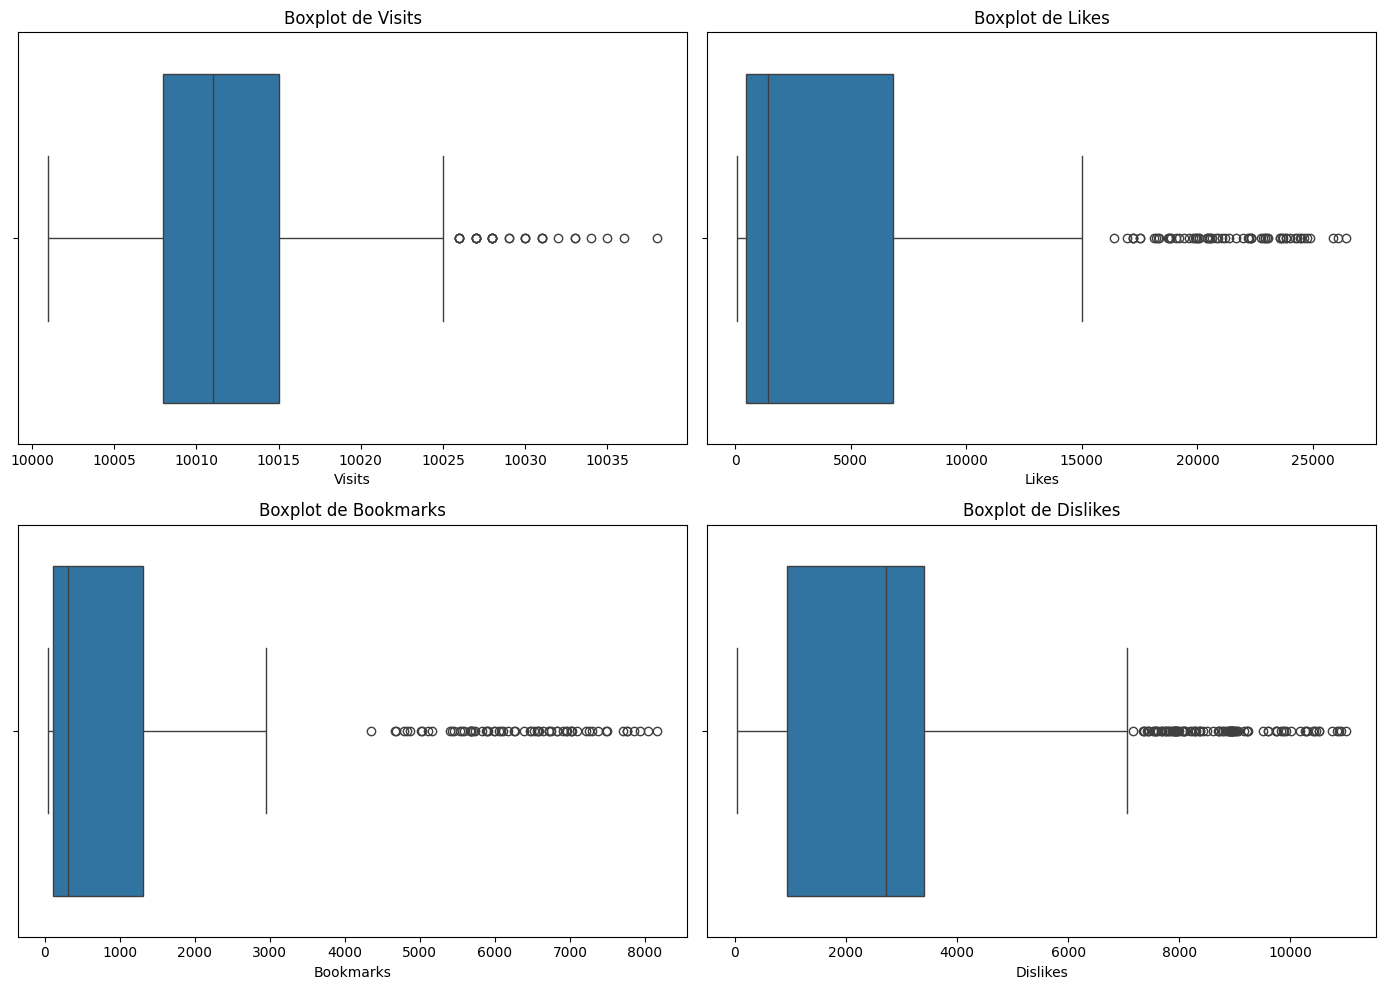

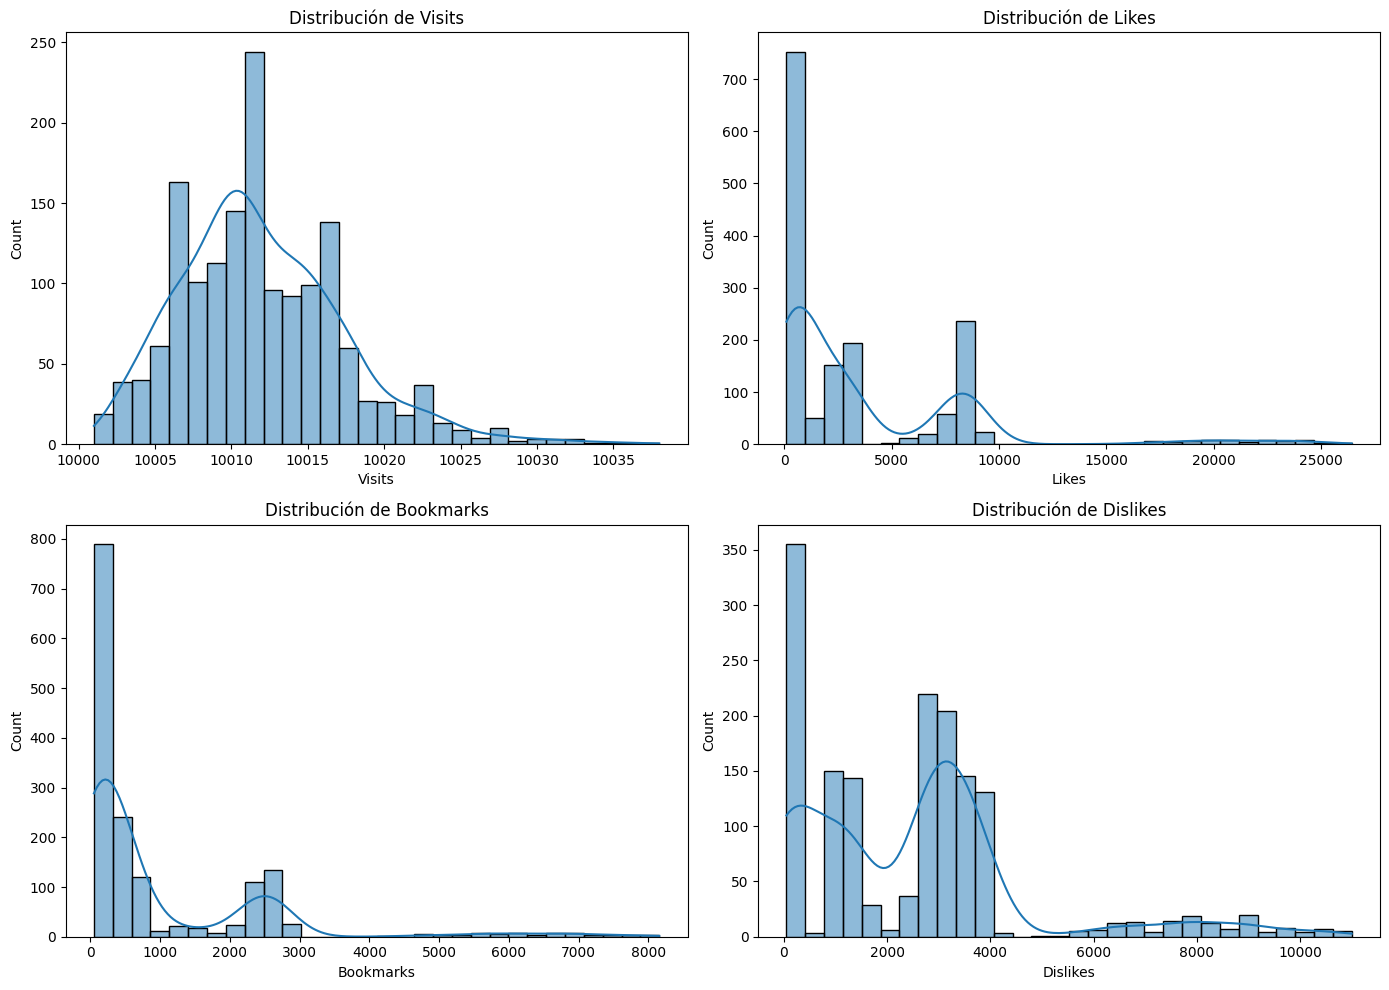

,count,mean,std,min,25%,50%,75%,max
Visits,1569.0,10011.943276,5.456808,10001.0,10008.0,10011.0,10015.0,10038.0
Likes,1569.0,3623.908222,4817.879374,100.0,464.0,1434.0,6840.0,26425.0
Bookmarks,1569.0,973.261950,1453.333948,50.0,116.0,306.0,1309.0,8157.0
Dislikes,1569.0,2526.305927,2225.543360,52.0,937.0,2718.0,3399.0,10999.0


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

cols = ["Visits", "Likes", "Bookmarks", "Dislikes"]

# Boxplots para detectar outliers
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
for i, col in enumerate(cols):
    sns.boxplot(data=df, x=col, ax=axes[i//2][i%2])
    axes[i//2][i%2].set_title(f"Boxplot de {col}")
plt.tight_layout()
plt.show()

# Histogramas para visualizar sesgo y acumulación
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
for i, col in enumerate(cols):
    sns.histplot(df[col], bins=30, ax=axes[i//2][i%2], kde=True)
    axes[i//2][i%2].set_title(f"Distribución de {col}")
plt.tight_layout()
plt.show()

# Estadísticas descriptivas
df[cols].describe().transpose()


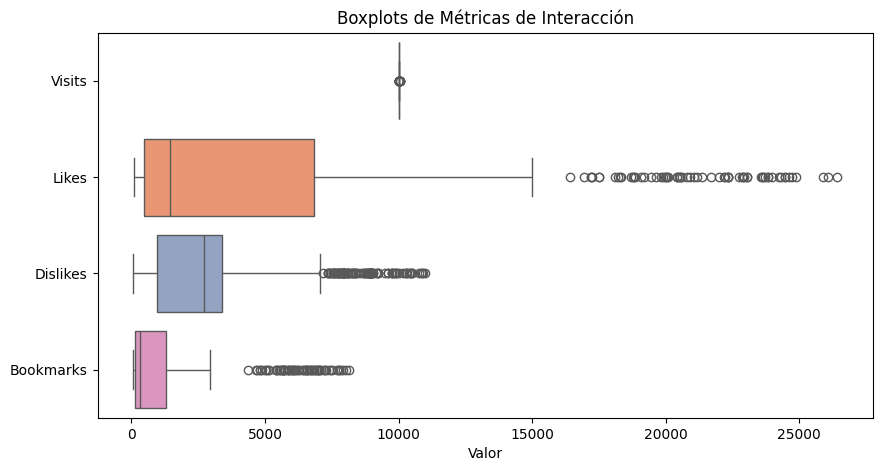

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Variables de interacción que componen el engagement_score
metricas_interaccion = ["Visits", "Likes", "Dislikes", "Bookmarks"]

# Filtrar solo esas columnas (asegúrate de que estén en df)
df_box = df[metricas_interaccion].copy()

# Boxplots
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_box, orient="h", palette="Set2")
plt.title("Boxplots de Métricas de Interacción")
plt.xlabel("Valor")
plt.show()


### Observaciones del análisis previo:

- `Visits` tiene una distribución muy estrecha y poco informativa, concentrada entre 10000 y 10040.
- `Likes`, `Bookmarks` y `Dislikes` presentan alta dispersión, asimetría positiva y varios outliers.
- Se observa que algunas métricas superan los 20.000 registros (Likes) o 10.000 (Dislikes).
- Estas diferencias de escala justifican aplicar `log1p()` a todas las variables, para suavizar los valores grandes y evitar que `Visits` o `Likes` dominen la combinación final.

> Con base en estas observaciones, se construye una métrica ponderada para capturar el engagement total.


In [10]:
import numpy as np

# Cálculo del engagement_score con pesos relativos y logaritmo suavizado
df["engagement_score"] = (
    np.log1p(df["Visits"]) * 0.4 +
    np.log1p(df["Likes"]) * 0.3 +
    np.log1p(df["Bookmarks"]) * 0.3 -
    np.log1p(df["Dislikes"]) * 0.4
)


Esta combinación ponderada busca reflejar un balance entre el interés general (`Visits`), la valoración positiva (`Likes` y `Bookmarks`) y la señal negativa (`Dislikes`).

Se asignaron los siguientes pesos:
- `0.4` a `Visits` por representar una señal sólida de interés general, aunque con poca varianza.
- `0.3` a `Likes` y `Bookmarks`, al tratarse de señales más específicas de valor percibido por el usuario.
- `-0.4` a `Dislikes`, para penalizar fuertemente las valoraciones negativas, ya que representan desinterés o rechazo.

La función `log1p()` se utiliza para suavizar los valores extremos sin perder información relevante, especialmente útil ante la presencia de outliers.

In [11]:
# Umbral seleccionado: percentil 60
threshold_60 = df["engagement_score"].quantile(0.6)

# Creación de la etiqueta binaria
df["engagement_target"] = (df["engagement_score"] >= threshold_60).astype(int)

# Verificación de la distribución de clases
df["engagement_target"].value_counts(normalize=True).rename_axis("clase").to_frame("proporción")


,proporción
clase,
0,0.599745
1,0.400255


Se selecciona el **percentil 60** como umbral para definir qué POIs presentan un engagement alto. Esto genera una distribución más balanceada entre clases (aproximadamente 40% clase 1 y 60% clase 0), manteniendo un volumen representativo para ambas categorías.

Este target será la variable `y` que el modelo intentará predecir en las siguientes etapas.

> Las columnas utilizadas para construir la variable objetivo (`Visits`, `Likes`, `Bookmarks`, `Dislikes`) serán eliminadas del conjunto de entrenamiento posteriormente para evitar *data leakage*.


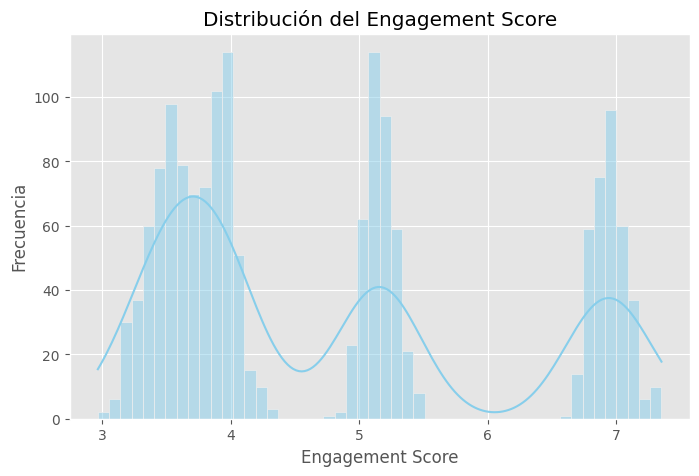

<ipython-input-12-2237626415>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['engagement_target'], palette="Set2")


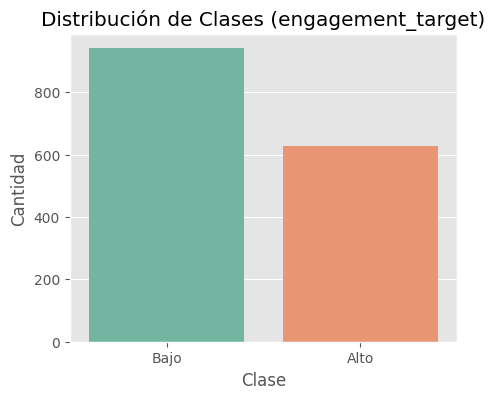

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Estilo general
plt.style.use("ggplot")

# Histograma del engagement_score
plt.figure(figsize=(8, 5))
sns.histplot(df['engagement_score'], bins=50, kde=True, color="skyblue")
plt.title("Distribución del Engagement Score")
plt.xlabel("Engagement Score")
plt.ylabel("Frecuencia")
plt.show()

# Conteo de clases engagement_target
plt.figure(figsize=(5, 4))
sns.countplot(x=df['engagement_target'], palette="Set2")
plt.title("Distribución de Clases (engagement_target)")
plt.xlabel("Clase")
plt.ylabel("Cantidad")
plt.xticks([0, 1], ["Bajo", "Alto"])
plt.show()


## 5. División del dataset: train / validation / test

Siguiendo el enfoque trabajado en clase, el dataset se divide en tres subconjuntos:

1. Se separa un 20% de los datos para el conjunto de test (`df_test`), que se utilizará únicamente al final para la evaluación definitiva del modelo.
2. El 80% restante se divide en dos subconjuntos:
   - 80% para entrenamiento (`df_train`)
   - 20% para validación (`df_val`)

Esta estructura permite reservar un conjunto de test realista y mantener un conjunto de validación interno durante el desarrollo. Se utiliza partición **estratificada** sobre `engagement_target` para preservar el balance de clases.



In [13]:
from sklearn.model_selection import train_test_split

#separamos test (20% del total)
df_base, df_test = train_test_split(
    df,
    test_size=0.2,
    stratify=df["engagement_target"],
    random_state=seed
)

# separamos train y val (80% y 20% de lo que quedó)
df_train, df_val = train_test_split(
    df_base,
    test_size=0.2,
    stratify=df_base["engagement_target"],
    random_state=seed
)

# Verificar tamaños
print(f"Train: {df_train.shape[0]} filas")
print(f"Val:   {df_val.shape[0]} filas")
print(f"Test:  {df_test.shape[0]} filas")


Train: 1004 filas
Val:   251 filas
Test:  314 filas


In [14]:
# Revisión del balance de clases en cada subset
for name, subset in [("Train", df_train), ("Val", df_val), ("Test", df_test)]:
    dist = subset["engagement_target"].value_counts(normalize=True).to_dict()
    print(f"{name} → Clase 0: {dist.get(0, 0):.2f}, Clase 1: {dist.get(1, 0):.2f}")


Train → Clase 0: 0.60, Clase 1: 0.40
Val → Clase 0: 0.60, Clase 1: 0.40
Test → Clase 0: 0.60, Clase 1: 0.40


Esta estrategia de división permite:

- Reservar un conjunto de test totalmente aislado para evaluación final.
- Disponer de un conjunto de validación para ajustar hiperparámetros y prevenir overfitting.
- Mantener la proporción de clases en cada partición gracias al uso de estratificación.

Esta estructura es la recomendada en proyectos reales de machine learning y sigue el enfoque explicado por el profesor en clase.


## 6. Análisis exploratorio y preprocesamiento

En esta sección se realiza un análisis inicial detallado del conjunto de entrenamiento, seguido de la preparación de los datos estructurados para su uso en el modelo.

**Análisis exploratorio (EDA):**
- Exploración de la distribución de las variables clave (`visits`, `likes`, `dislikes`, `bookmarks`, `xps`, `tier`, coordenadas geográficas).
- Detección visual y cuantitativa de posibles outliers.
- Revisión del balance de clases en la variable objetivo `engagement_target`.
- Verificación de la cardinalidad de variables categóricas como `categories` y `tags`.

**Preprocesamiento:**
- Imputación de valores nulos utilizando estrategias diferenciadas para variables numéricas y categóricas.
- Codificación de variables multilabel (`categories`, `tags`) usando `MultiLabelBinarizer`, filtrando los valores menos frecuentes para evitar alta dimensionalidad.
- Escalado de variables numéricas (`xps`, `tier`, `locationLat`, `locationLon`) utilizando `StandardScaler`, ajustado exclusivamente sobre `df_train`.
- Eliminación de columnas no relevantes para el modelo (`id`, `name`, `shortDescription`).
- Separación final de las variables predictoras (`X`) y la variable objetivo (`y`), dejando `main_image_path` como referencia para la rama visual del modelo.

> Todo el preprocesamiento fue realizado exclusivamente sobre el conjunto de entrenamiento (`df_train`) y aplicado a `df_val` y `df_test` usando los mismos parámetros, respetando así las buenas prácticas y evitando *data leakage*.


In [15]:
# Ver dimensiones
print(f"Filas: {df_train.shape[0]}, Columnas: {df_train.shape[1]}")

# Tipos de datos
df_train.dtypes.value_counts()


Filas: 1004, Columnas: 16


,count
int64,7
object,6
float64,3


In [16]:
# Revisión de valores nulos
df_train.isna().sum().sort_values(ascending=False).head(15)


,0
id,0
name,0
shortDescription,0
categories,0
tier,0
locationLon,0
locationLat,0
tags,0
xps,0
Visits,0


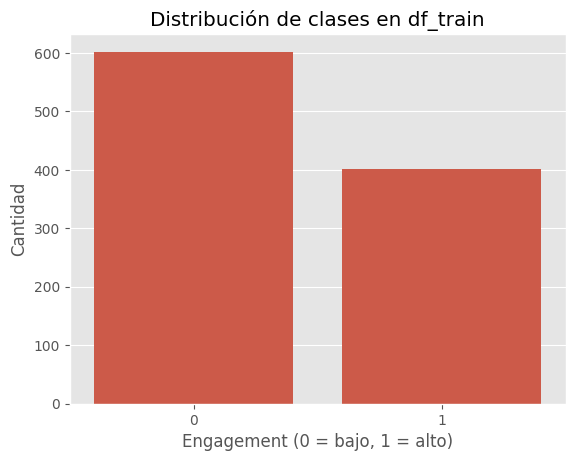

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df_train, x="engagement_target")
plt.title("Distribución de clases en df_train")
plt.xlabel("Engagement (0 = bajo, 1 = alto)")
plt.ylabel("Cantidad")
plt.show()


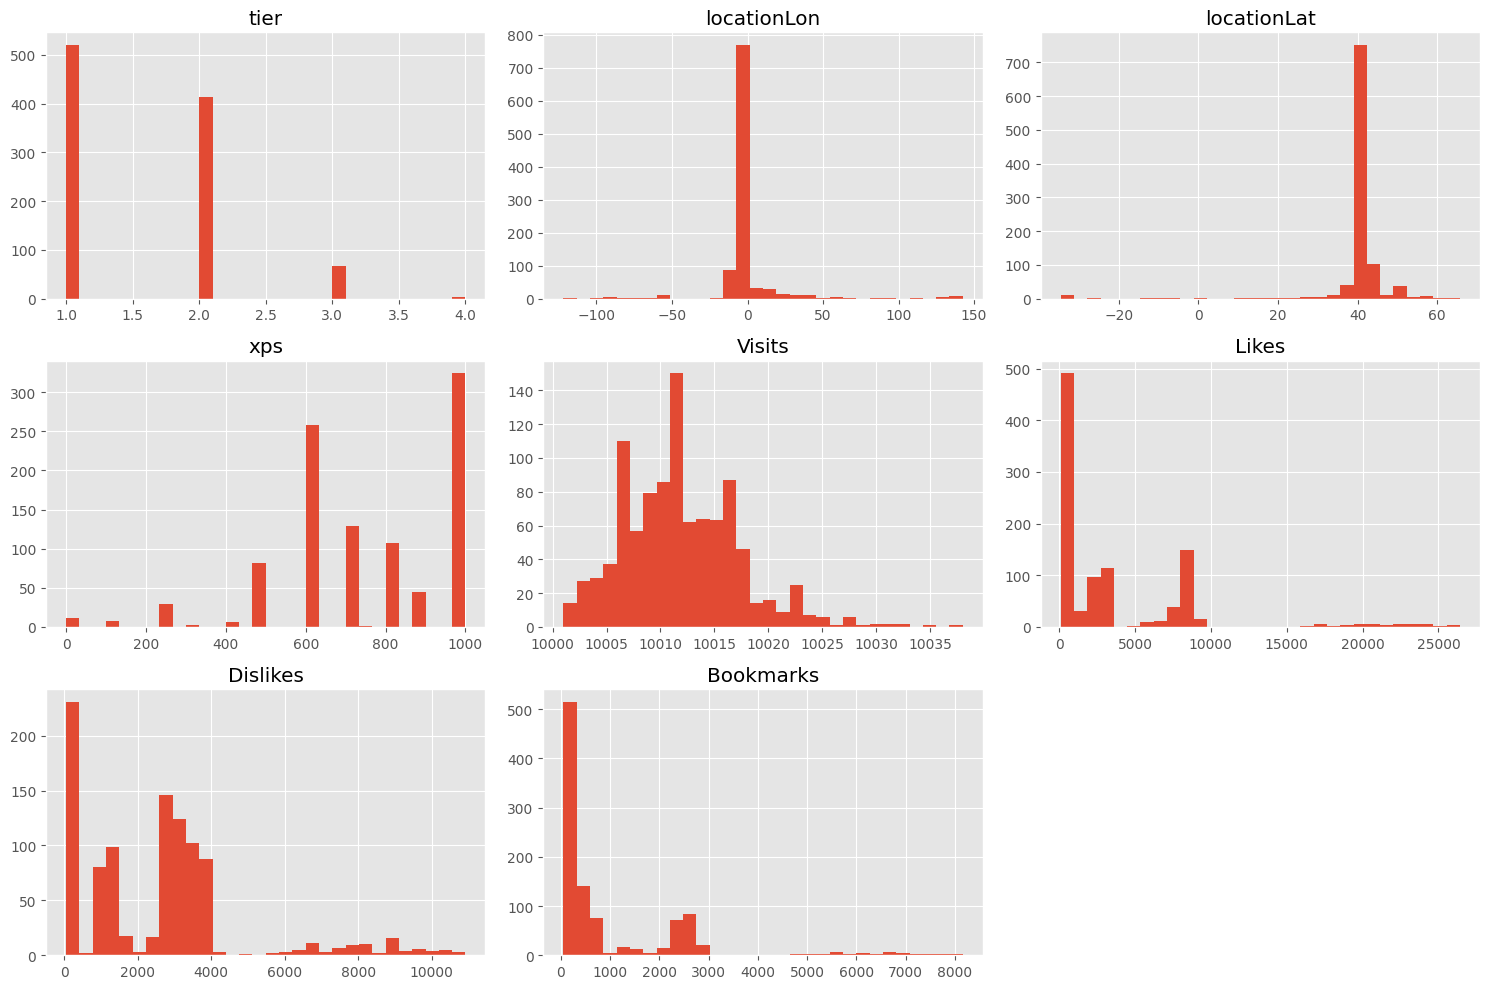

In [18]:
# Selección de columnas numéricas excluyendo engagement_score/target
numericas = df_train.select_dtypes(include="number").drop(columns=["engagement_score", "engagement_target"])

# Histograma de las principales variables numéricas
numericas.hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()


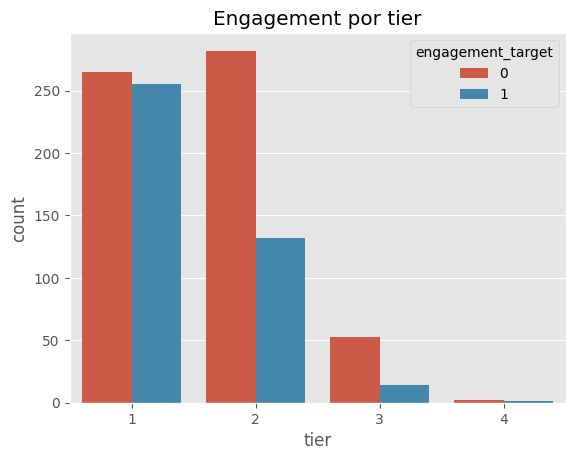

In [19]:
# Ejemplo: relación entre tier y engagement
sns.countplot(data=df_train, x="tier", hue="engagement_target")
plt.title("Engagement por tier")
plt.show()



- No se encontraron valores nulos en ninguna de las columnas del conjunto de entrenamiento.
- Las variables están distribuidas entre numéricas (`int64`, `float64`) y categóricas (`object`).
- La variable `engagement_target` muestra una distribución razonablemente balanceada (aproximadamente 60/40), lo que facilitará el entrenamiento.
- Las variables `Likes`, `Bookmarks` y `Dislikes` presentan fuerte sesgo positivo y valores atípicos, ya vistos anteriormente en el diseño del `engagement_score`.
- Aunque estas variables no formarán parte de las variables predictoras (serán eliminadas en el preprocesamiento), se analizan aquí como parte del proceso de validación del diseño del target.
- El análisis cruzado de `tier` con `engagement_target` muestra posibles diferencias entre categorías, lo cual será útil para el modelo.


## Preprocesamiento de datos

En esta sección se prepara el conjunto de datos para ser utilizado por el modelo de deep learning. El preprocesamiento se aplica únicamente sobre el conjunto de entrenamiento (`df_train`) y se replica sobre `df_val` y `df_test` para evitar *data leakage*.

Las transformaciones incluyen:
- Eliminación de columnas utilizadas para construir el target
- Imputación (si hubiera valores nulos)
- Normalización de variables numéricas
- Codificación de variables categóricas

> Todas las transformaciones se ajustan exclusivamente con `df_train` y se aplican luego a `df_val` y `df_test`.


In [20]:
# Columnas que se usaron para construir engagement_score y engagement_target
leakage_cols = ["Visits", "Likes", "Bookmarks", "Dislikes"]

# Eliminarlas de los tres datasets
df_train = df_train.drop(columns=leakage_cols)
df_val = df_val.drop(columns=leakage_cols)
df_test = df_test.drop(columns=leakage_cols)


Antes de aplicar transformaciones, se identifican qué columnas se consideran **numéricas** y cuáles **categóricas**, excluyendo las columnas `id`, `main_image_path`, `engagement_score` y `engagement_target`, que no serán utilizadas como variables predictoras:

- `id` y `main_image_path` son identificadores o rutas → no aportan valor predictivo.
- `engagement_score` es una variable intermedia no útil para predicción.
- `engagement_target` es la variable objetivo (`y`).

> Solo se trabajará sobre las columnas útiles para la entrada del modelo (`X`).
> La columna `main_image_path` no se utilizará como input para el modelo tabular, pero se conserva para enlazar con las imágenes correspondientes en la rama CNN del modelo multimodal.



In [21]:
# Columnas a excluir del modelo
excluir = ["id", "main_image_path", "engagement_score", "engagement_target"]

# Columnas disponibles para X
columnas_X = [col for col in df_train.columns if col not in excluir]

# Separar variables numéricas y categóricas
num_cols = df_train[columnas_X].select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = df_train[columnas_X].select_dtypes(include=["object"]).columns.tolist()

print("Variables numéricas:", num_cols)
print("Variables categóricas:", cat_cols)


Variables numéricas: ['tier', 'locationLon', 'locationLat', 'xps']
Variables categóricas: ['name', 'shortDescription', 'categories', 'tags']


Aunque en el análisis exploratorio no se detectaron valores nulos, se aplica una estrategia de imputación por si en los subconjuntos de validación o test aparecen casos.

- Para variables numéricas: se imputa con la **mediana**.
- Para variables categóricas: se imputa con la **categoría más frecuente (moda)**.

In [22]:
from sklearn.impute import SimpleImputer

# Imputadores
imputer_num = SimpleImputer(strategy="median")
imputer_cat = SimpleImputer(strategy="most_frequent")

# Ajustar solo con df_train
df_train[num_cols] = imputer_num.fit_transform(df_train[num_cols])
df_val[num_cols] = imputer_num.transform(df_val[num_cols])
df_test[num_cols] = imputer_num.transform(df_test[num_cols])

df_train[cat_cols] = imputer_cat.fit_transform(df_train[cat_cols])
df_val[cat_cols] = imputer_cat.transform(df_val[cat_cols])
df_test[cat_cols] = imputer_cat.transform(df_test[cat_cols])


Antes de codificar la variable multietiqueta `categories`, se realiza un análisis de frecuencia para entender cuántas categorías distintas existen y cuán frecuentes son.

Este paso permite tomar decisiones informadas sobre:
- Cuántas categorías incluir en la codificación final.
- Si es necesario agrupar etiquetas poco frecuentes bajo una categoría genérica como `"otros"`.
- Evitar una explosión de columnas innecesarias en la codificación.

> Se grafica el Top de categorías más frecuentes en el conjunto de entrenamiento (`df_train`), sin modificar los datos originales.


In [23]:
import ast
from collections import Counter

# Asegurar que 'categories' sea una lista real
df_train["categories_tmp"] = df_train["categories"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Contar todas las categorías únicas
category_counter = Counter(cat for cat_list in df_train["categories_tmp"] for cat in cat_list)

# Mostrar resultado
print(f"Total de categorías únicas en df_train: {len(category_counter)}")

# Opcional: mostrar las categorías si querés
print("\nCategorías únicas:")
for cat in sorted(category_counter):
    print(f"- {cat}")

# Limpieza
df_train.drop(columns=["categories_tmp"], inplace=True)


Total de categorías únicas en df_train: 12

Categorías únicas:
- Arquitectura
- Ciencia
- Cine
- Cultura
- Escultura
- Gastronomía
- Historia
- Misterio
- Naturaleza
- Ocio
- Patrimonio
- Pintura


Top categorías más frecuentes en df_train:
Historia: 825
Cultura: 670
Arquitectura: 425
Patrimonio: 380
Escultura: 315
Misterio: 229
Ciencia: 80
Ocio: 49
Pintura: 32
Naturaleza: 28
Cine: 15
Gastronomía: 8


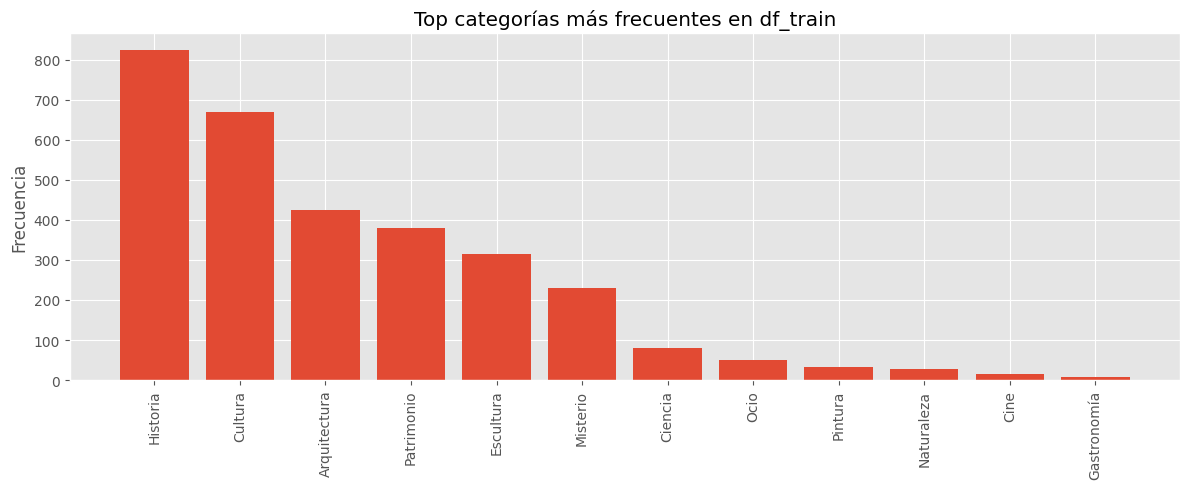

In [24]:
import ast
import matplotlib.pyplot as plt
from collections import Counter

# Asegurar que la columna 'categories' tenga listas reales
df_train["categories_tmp"] = df_train["categories"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Contar frecuencia de todas las categorías
category_counter = Counter(cat for cats in df_train["categories_tmp"] for cat in cats)

# Obtener top categorías
top_cats = category_counter.most_common(12)

# Imprimir en consola
print("Top categorías más frecuentes en df_train:")
for cat, freq in top_cats:
    print(f"{cat}: {freq}")

# Visualización en gráfico de barras
cats, freqs = zip(*top_cats)
plt.figure(figsize=(12, 5))
plt.bar(cats, freqs)
plt.xticks(rotation=90)
plt.title("Top categorías más frecuentes en df_train")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

# Limpieza temporal
df_train = df_train.drop(columns=["categories_tmp"])



De forma similar a `categories`, se analiza la frecuencia de las distintas etiquetas presentes en la variable `tags`, que contiene múltiples palabras clave asociadas a cada POI.

Este análisis ayuda a:
- Detectar etiquetas frecuentes que pueden ser útiles como input al modelo.
- Determinar un umbral de frecuencia para seleccionar los `tags` más representativos.
- Prevenir una codificación dispersa y costosa generada por etiquetas poco comunes.

> Se visualiza el Top 40 de `tags` más frecuentes en el conjunto de entrenamiento (`df_train`), sin alterar el dataset.


In [25]:
import ast
from collections import Counter

# Asegurar que la columna 'tags' sea lista real
df_train["tags_tmp"] = df_train["tags"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Contar frecuencia de todos los tags
tag_counter = Counter(tag for tag_list in df_train["tags_tmp"] for tag in tag_list)

# Mostrar cantidad total de tags únicos
print(f"Total de tags únicos en df_train: {len(tag_counter)}")

# Limpiar columna temporal
df_train.drop(columns=["tags_tmp"], inplace=True)


Total de tags únicos en df_train: 2212


In [26]:
import ast
from collections import Counter

# Asegurar que los tags sean listas reales
df_train["tags_tmp"] = df_train["tags"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Contar frecuencia total de todos los tags
tag_counter = Counter(tag for tag_list in df_train["tags_tmp"] for tag in tag_list)

# Filtrar tags que aparecen más de 30 veces
min_freq = 20
top_tags = {tag for tag, count in tag_counter.items() if count > min_freq}

# Mostrar resultados
print(f"Total de tags únicos con más de {min_freq} apariciones: {len(top_tags)}\n")
print("Tags seleccionados:")
for tag in sorted(top_tags):
    print(f"- {tag}")

# Limpieza temporal
df_train.drop(columns=["tags_tmp"], inplace=True)


Total de tags únicos con más de 20 apariciones: 55

Tags seleccionados:
- Arquitectura
- Arte
- Casa de campo
- Centro
- Comunidad
- Conservación
- Cultura
- Distrito
- Edificios
- Educación
- Escultura
- Escultura conceptual o abstracta
- Espacio público
- Espiritualidad
- Estatua
- Galicia
- Gran Vía
- Grupo escultórico
- Historia
- Homenaje
- Iglesia
- Iglesias
- Innovación
- Jardines
- Jerónimos
- Legado
- Literatura
- Madrid
- Modernidad
- Moncloa-aravaca
- Monumento
- Naturaleza
- Paisaje
- Palacio
- Parque
- Parque del retiro
- Patrimonio
- Política
- Puerta, arco triunfal
- Realeza
- Reflexión
- Reformas
- Rehabilitación
- Religión
- Resiliencia
- Restauración
- Retiro
- Salamanca
- Simbolismo
- Símbolo
- Tradición
- Transformación
- Turismo
- Urbanismo
- Yacimientos


Top tags más frecuentes en df_train:

Historia: 527
Madrid: 475
Cultura: 395
Arquitectura: 262
Patrimonio: 233
Escultura: 226
Arte: 222
Estatua: 184
Monumento: 105
Naturaleza: 92
Restauración: 83
Educación: 67
Grupo escultórico: 66
Escultura conceptual o abstracta: 65
Centro: 63
Retiro: 57
Urbanismo: 55
Homenaje: 54
Jerónimos: 52
Galicia: 51
Palacio: 48
Moncloa-aravaca: 47
Turismo: 47
Religión: 44
Legado: 40
Gran Vía: 40
Innovación: 38
Yacimientos: 36
Distrito: 34
Comunidad: 34
Parque del retiro: 32
Reflexión: 32
Literatura: 32
Puerta, arco triunfal: 31
Conservación: 31
Rehabilitación: 31
Casa de campo: 30
Parque: 30
Resiliencia: 29
Jardines: 29
Simbolismo: 29
Realeza: 28
Iglesias: 28
Modernidad: 27
Tradición: 27
Reformas: 27
Espiritualidad: 26
Iglesia: 26
Edificios: 24
Espacio público: 24


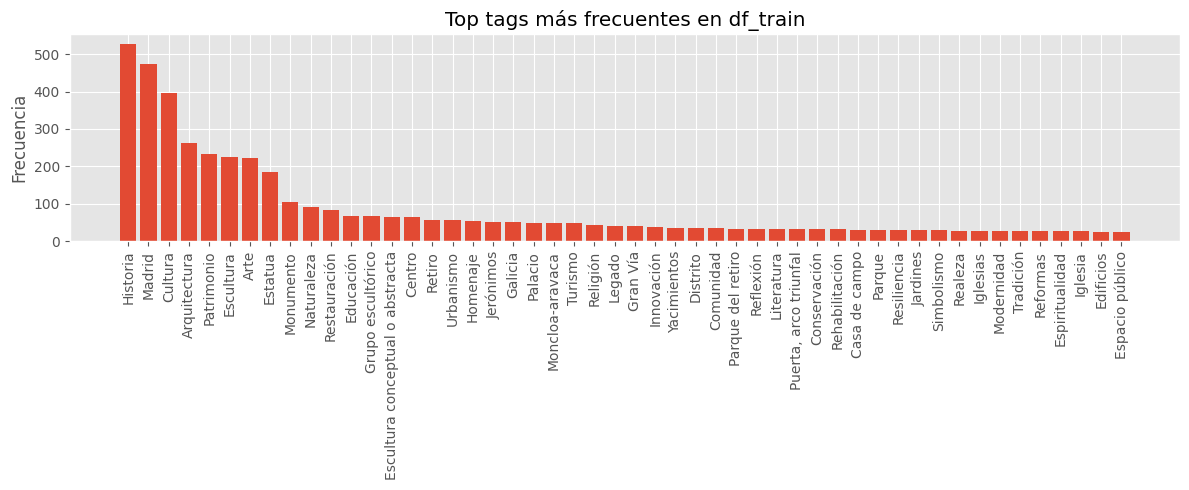

In [27]:
import ast
import matplotlib.pyplot as plt
from collections import Counter

# Asegurarse de que 'tags' esté como lista real
df_train["tags_tmp"] = df_train["tags"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Contar frecuencia de todos los tags en df_train
tag_counter = Counter(tag for tag_list in df_train["tags_tmp"] for tag in tag_list)

# Mostrar top 50 tags
top_tags = tag_counter.most_common(50)
print("Top tags más frecuentes en df_train:\n")
for tag, freq in top_tags:
    print(f"{tag}: {freq}")

# Visualización
tags, freqs = zip(*top_tags)
plt.figure(figsize=(12, 5))
plt.bar(tags, freqs)
plt.xticks(rotation=90)
plt.title("Top tags más frecuentes en df_train")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

# Limpiar columna temporal
df_train.drop(columns=["tags_tmp"], inplace=True)


### Codificación de variables multietiqueta: `categories` y `tags`

Las columnas `categories` y `tags` contienen listas de múltiples etiquetas por muestra (multilabel). Para su uso en modelos de aprendizaje automático, ambas se transforman en variables binarias mediante `MultiLabelBinarizer`.

#### `categories`:
- Contiene 12 categorías únicas en `df_train`.
- No se aplica filtrado: se codifican todas.

#### `tags`:
- Tiene un total de 2.212 valores únicos.
- Se seleccionan los **50 tags más frecuentes** en `df_train`.
- Los tags que no están en ese Top 50 son **descartados** (no se agrupan como `"otros"` para evitar ruido semántico).


In [28]:
from sklearn.preprocessing import MultiLabelBinarizer
from collections import Counter
import ast
import pandas as pd

# Preparar categories
# Asegurar formato lista
df_train["categories"] = df_train["categories"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Codificar con MultiLabelBinarizer (todas las categorías)
mlb_cat = MultiLabelBinarizer()
categories_encoded = mlb_cat.fit_transform(df_train["categories"])
cat_feature_names = [f"cat_{c}" for c in mlb_cat.classes_]
df_categories = pd.DataFrame(categories_encoded, columns=cat_feature_names, index=df_train.index)

# Preparar tags
# Asegurar formato lista
df_train["tags"] = df_train["tags"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Contar frecuencia de tags y seleccionar top 50
tag_counter = Counter(tag for tags in df_train["tags"] for tag in tags)
top_tags = {tag for tag, count in tag_counter.items() if count >= sorted(tag_counter.values(), reverse=True)[49]}

# Filtrar tags que no estén en el top 50
df_train["tags_filtradas"] = df_train["tags"].apply(lambda tags: [t for t in tags if t in top_tags])

# Codificar tags filtrados
mlb_tag = MultiLabelBinarizer()
tags_encoded = mlb_tag.fit_transform(df_train["tags_filtradas"])
tag_feature_names = [f"tag_{t}" for t in mlb_tag.classes_]
df_tags = pd.DataFrame(tags_encoded, columns=tag_feature_names, index=df_train.index)

# Integrar en df_train
# Eliminar columnas originales
df_train.drop(columns=["categories", "tags", "tags_filtradas"], inplace=True)

# Concatenar codificaciones
df_train = pd.concat([df_train, df_categories, df_tags], axis=1)

# Resultado
print(f"Dataset codificado correctamente. Nuevas dimensiones: {df_train.shape}")


Dataset codificado correctamente. Nuevas dimensiones: (1004, 72)


### Codificación de `categories` y `tags` en los conjuntos de validación y test

Para mantener la consistencia con el conjunto de entrenamiento (`df_train`), se aplica el mismo procedimiento de codificación binaria a `df_val` y `df_test` utilizando los binarizadores ya ajustados (`mlb_cat` y `mlb_tag`) y el conjunto de `tags` más frecuentes (`top_tags`).

> Importante: no se vuelve a aplicar `.fit()` sobre los binarizadores, ya que eso provocaría data leakage. Solo se utiliza `.transform()` con los objetos entrenados en `train`.

La función `procesar_multilabel` realiza los siguientes pasos:
- Convierte las columnas `categories` y `tags` en listas reales.
- Filtra los `tags` que no están en el Top 50 más frecuentes.
- Codifica ambas columnas con `MultiLabelBinarizer`.
- Elimina las columnas originales y concatena las nuevas columnas binarias.

Se aplica luego a `df_val` y `df_test` para dejarlos listos para el preprocesamiento final.


In [29]:
def procesar_multilabel(df, mlb_cat, mlb_tag, top_tags):
    import ast
    import pandas as pd

    df = df.copy()

    # Preparar categories
    df["categories"] = df["categories"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    categories_encoded = mlb_cat.transform(df["categories"])
    df_categories = pd.DataFrame(categories_encoded, columns=[f"cat_{c}" for c in mlb_cat.classes_], index=df.index)

    # Preparar tags
    df["tags"] = df["tags"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    df["tags_filtradas"] = df["tags"].apply(lambda tags: [t for t in tags if t in top_tags])
    tags_encoded = mlb_tag.transform(df["tags_filtradas"])
    df_tags = pd.DataFrame(tags_encoded, columns=[f"tag_{t}" for t in mlb_tag.classes_], index=df.index)

    # Eliminar columnas originales y unir codificadas
    df.drop(columns=["categories", "tags", "tags_filtradas"], inplace=True)
    df = pd.concat([df, df_categories, df_tags], axis=1)

    return df

# Aplicar procesamiento
df_val = procesar_multilabel(df_val, mlb_cat, mlb_tag, top_tags)
df_test = procesar_multilabel(df_test, mlb_cat, mlb_tag, top_tags)

print(f"df_val codificado: {df_val.shape}")
print(f"df_test codificado: {df_test.shape}")


df_val codificado: (251, 72)
df_test codificado: (314, 72)


### Escalado de variables numéricas

Se escalaron las siguientes variables usando `StandardScaler`, ajustado solo con `df_train`:
- `xps`
- `tier`
- `locationLat`
- `locationLon`

Esto garantiza que todas las variables numéricas estén centradas en media 0 y desviación estándar 1, lo cual es especialmente importante en redes neuronales para una convergencia más estable.


In [30]:
from sklearn.preprocessing import StandardScaler

# Columnas numéricas a escalar
num_cols = ["xps", "tier", "locationLat", "locationLon"]

# Inicializar el escalador
scaler = StandardScaler()

# Ajustar en train y transformar en train
df_train[num_cols] = scaler.fit_transform(df_train[num_cols])

# Transformar en val y test con el mismo escalador
df_val[num_cols] = scaler.transform(df_val[num_cols])
df_test[num_cols] = scaler.transform(df_test[num_cols])

print("Variables numéricas escaladas correctamente en train, val y test")


Variables numéricas escaladas correctamente en train, val y test


### Preparación final de tensores y metadatos para el modelo multimodal

En esta sección se prepara el dataset para su uso en PyTorch, dividiendo correctamente las variables de entrada (`X`) y la variable objetivo (`y`), y manteniendo la referencia a las imágenes.

#### 🔹 Acciones realizadas:
- Se eliminaron columnas irrelevantes para el modelo: `id`, `name`, `shortDescription`.
- Se separaron `X` e `y`, conservando `main_image_path` como vínculo con las imágenes.
- Se dejó todo listo para construir un `Dataset` personalizado en PyTorch que maneje ambas ramas del modelo: la CNN (con imágenes) y la DNN (con metadatos).


In [31]:
# Eliminar columnas no necesarias para el modelo
cols_a_eliminar = ["name", "shortDescription"]
df_train.drop(columns=cols_a_eliminar, inplace=True)
df_val.drop(columns=cols_a_eliminar, inplace=True)
df_test.drop(columns=cols_a_eliminar, inplace=True)

# Separar X e y
y_train = df_train["engagement_target"].values
X_train = df_train.drop(columns=["engagement_target"])

y_val = df_val["engagement_target"].values
X_val = df_val.drop(columns=["engagement_target"])

y_test = df_test["engagement_target"].values
X_test = df_test.drop(columns=["engagement_target"])

# Confirmación de dimensiones
print(f"X_train shape: {X_train.shape} | y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape} | y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape} | y_test shape: {y_test.shape}")


X_train shape: (1004, 69) | y_train shape: (1004,)
X_val shape: (251, 69) | y_val shape: (251,)
X_test shape: (314, 69) | y_test shape: (314,)


## 7. Preparación de imágenes

En esta sección se prepara el componente visual del modelo multimodal, cargando las imágenes asociadas a cada POI desde la ruta indicada en la columna `main_image_path`.

- **Lectura de imágenes**: Se accede a cada archivo a partir del path relativo almacenado en el dataset.
- **Transformaciones**: Las imágenes se redimensionan a 224x224 píxeles, se convierten a tensores y se normalizan utilizando los valores medios y desviaciones estándar de ImageNet, ya que se utilizará transfer learning con arquitecturas preentrenadas.
- **Dataset personalizado (`torch.utils.data.Dataset`)**: Se define una clase que devuelve tripletas `(imagen_tensor, metadatos_tensor, etiqueta)`, unificando la información estructurada y visual para cada muestra.

Estas transformaciones aseguran que las imágenes estén listas para ser procesadas por redes convolucionales como ResNet o EfficientNet.


In [32]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os
import numpy as np
import pandas as pd

# Transformaciones estándar para imagen (ImageNet)
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

class POIDataset(Dataset):
    def __init__(self, X, y, image_base_path, transform=None):
        """
        X: DataFrame con columnas de metadatos + main_image_path
        y: vector de etiquetas (engagement_target)
        image_base_path: ruta base donde están almacenadas las imágenes
        transform: transformaciones a aplicar a la imagen
        """
        self.X = X.reset_index(drop=True)
        self.y = y
        self.image_base_path = image_base_path
        self.transform = transform

        # Filtrar solo columnas numéricas (excluyendo id y main_image_path)
        self.meta_features = [
            col for col in X.columns
            if col not in ['main_image_path', 'id']
            and pd.api.types.is_numeric_dtype(X[col])
        ]

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        row = self.X.iloc[idx]

        # Imagen
        image_path = os.path.join(self.image_base_path, row['main_image_path'])
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # Metadatos → float32
        meta_array = row[self.meta_features].values.astype(np.float32)
        meta = torch.from_numpy(meta_array)

        # Etiqueta
        label = torch.tensor(self.y[idx], dtype=torch.float32)

        return image, meta, label


## Creación de DataLoaders

Una vez definido el `Dataset` personalizado que combina imágenes y metadatos, se crean las instancias correspondientes para los subconjuntos `train`, `val` y `test`.

Luego, se construyen los `DataLoaders`, que permiten iterar sobre los datos en batches durante el entrenamiento y evaluación del modelo. Cada iteración devuelve una tupla con:

`(imagen_tensor, metadatos_tensor, etiqueta)`

- `imagen_tensor`: Tensor de forma `[3, 224, 224]` normalizado con estadísticas de ImageNet.
- `metadatos_tensor`: Vector de características estructuradas (preprocesadas y escaladas).
- `etiqueta`: Valor binario `0.0` o `1.0` correspondiente a `engagement_target`.

Se recomienda `shuffle=True` únicamente para el conjunto de entrenamiento, para garantizar aleatoriedad en cada época.


In [33]:
from torch.utils.data import DataLoader

# Instanciación de datasets (con X e y separados)
train_dataset = POIDataset(X_train, y_train, image_base_path=".", transform=image_transforms)
val_dataset   = POIDataset(X_val,   y_val,   image_base_path=".", transform=image_transforms)
test_dataset  = POIDataset(X_test,  y_test,  image_base_path=".", transform=image_transforms)

# Creación de los DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)


##8. Arquitectura del modelo multimodal

El modelo propuesto combina dos fuentes de información complementarias: imágenes y metadatos estructurados. Para ello, se define una arquitectura multimodal con dos ramas paralelas que se fusionan antes de la clasificación final.

- **Rama CNN (visual):**  
  Se utiliza un modelo convolucional preentrenado (ResNet18), congelando sus pesos. Se elimina su capa final (`fc`) para extraer un vector de características visuales.

- **Rama DNN (estructurada):**  
  Red neuronal completamente conectada (fully connected) que procesa los metadatos escalados. Incluye capas lineales, activaciones `ReLU` y dropout para evitar overfitting.

- **Fusión de ambas ramas:**  
  Los vectores de ambas salidas se concatenan y se pasan por capas densas adicionales que actúan como clasificador.

- **Capa de salida:**  
  Una capa lineal seguida de una activación `Sigmoid` para producir una única probabilidad que indica el nivel de engagement (alto o bajo).

Esta arquitectura permite capturar tanto los patrones visuales como la información contextual del POI para realizar una predicción más robusta.


In [34]:
import torch
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights

# Transformaciones oficiales de ImageNet asociadas a ResNet18
weights = ResNet18_Weights.DEFAULT
image_transforms = weights.transforms()

class MultimodalNet(nn.Module):
    def __init__(self, num_meta_features, dropout_p=0.3):
        super(MultimodalNet, self).__init__()

        # Rama CNN - ResNet18 preentrenada sin warning
        self.cnn = resnet18(weights=weights)

        # Congelar pesos de la red convolucional
        for param in self.cnn.parameters():
            param.requires_grad = False

        # Quitar la capa fc
        num_cnn_features = self.cnn.fc.in_features
        self.cnn = nn.Sequential(*list(self.cnn.children())[:-1])

        # Rama DNN - metadatos estructurados
        self.dnn = nn.Sequential(
            nn.Linear(num_meta_features, 128),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(128, 64),
            nn.ReLU()
        )

        # Clasificador final tras la fusión
        self.classifier = nn.Sequential(
            nn.Linear(num_cnn_features + 64, 64),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, image, meta):
        # Imagen → CNN → vector
        cnn_out = self.cnn(image)
        cnn_out = cnn_out.view(cnn_out.size(0), -1)

        # Metadatos → DNN
        meta_out = self.dnn(meta)

        # Fusión → Clasificación
        combined = torch.cat((cnn_out, meta_out), dim=1)
        output = self.classifier(combined)
        return output


### Verificación previa al entrenamiento

Antes de iniciar el entrenamiento, realizamos una prueba de `forward` con un batch real para asegurarnos de que:

- La arquitectura del modelo multimodal funciona correctamente.
- Las formas de los tensores de imagen y metadatos encajan con lo esperado.
- No se producen errores al pasar los datos por ambas ramas del modelo.


In [35]:
# Número de features estructurales (excluyendo columnas no numéricas)
meta_columns = [col for col in df_train.columns if col not in ['main_image_path', 'engagement_target', 'id']]
num_meta_features = len(meta_columns)

# Reinstanciar el modelo por si lo necesitás
model = MultimodalNet(num_meta_features=num_meta_features)

# Verificar un batch real del DataLoader
batch = next(iter(train_loader))
images, meta, labels = batch

# Forward sin entrenamiento
with torch.no_grad():
    outputs = model(images, meta)

print("Forward exitoso")
print("Output shape:", outputs.shape)
print("Output ejemplo:", outputs[:5].view(-1).numpy())



Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 201MB/s]


Forward exitoso
Output shape: torch.Size([32, 1])
Output ejemplo: [0.48116735 0.49470985 0.50044096 0.5621439  0.5180242 ]


## 9. Entrenamiento del modelo

En esta etapa se entrena el modelo multimodal utilizando un enfoque supervisado para predecir el nivel de engagement de los POIs. Se sigue un esquema clásico de entrenamiento con validación por épocas, incluyendo regularización y monitoreo de métricas.

- **Función de pérdida:**  
  Se utiliza `Binary Cross Entropy` (`BCELoss`) dado que se trata de un problema de clasificación binaria con salida tipo probabilidad (`Sigmoid`).

- **Métricas de evaluación:**  
  Se monitorizan `Accuracy` y `F1-score` en el conjunto de validación para evaluar el rendimiento del modelo más allá del umbral de clasificación.

- **Optimizador:**  
  Se emplea `Adam`, un optimizador eficiente y ampliamente utilizado para entrenamiento de redes neuronales.

- **Regularización y Early Stopping:**  
  Se aplica regularización mediante:
  - `Dropout` en las capas densas del modelo.
  - `L2` (weight decay) en el optimizador.
  Además, se incorpora una estrategia de **early stopping** basada en la métrica de validación para prevenir overfitting y detener el entrenamiento si no se observa mejora después de cierto número de épocas.

Este enfoque permite obtener un modelo robusto y generalizable que combina información visual y estructurada.


In [36]:
import torch
import torch.nn as nn
from torch.optim import Adam
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

# Calcular número de features estructurales
meta_features = [col for col in X_train.columns if col not in ['main_image_path', 'id']]
num_meta_features = len(meta_features)

# Instanciar el modelo
model = MultimodalNet(num_meta_features=num_meta_features, dropout_p=0.3)

# Configuración general
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

n_epochs = 50
patience = 5
best_val_f1 = 0
early_stop_counter = 0

# Historial de pérdida
history_train_loss = []
history_val_loss = []

for epoch in range(n_epochs):
    model.train()
    train_losses = []

    for images, meta, labels in train_loader:
        images = images.to(device)
        meta = meta.to(device)
        labels = labels.to(device).unsqueeze(1)

        outputs = model(images, meta)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    model.eval()
    val_preds = []
    val_labels = []
    val_losses = []

    with torch.no_grad():
        for images, meta, labels in val_loader:
            images = images.to(device)
            meta = meta.to(device)
            labels = labels.to(device).unsqueeze(1)

            outputs = model(images, meta)
            loss = criterion(outputs, labels)
            val_losses.append(loss.item())

            val_preds.extend(outputs.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    # Guardar historial de pérdida
    history_train_loss.append(np.mean(train_losses))
    history_val_loss.append(np.mean(val_losses))

    # Métricas
    val_preds_binary = (np.array(val_preds) > 0.5).astype(int)
    val_labels_binary = (np.array(val_labels) > 0.5).astype(int)

    val_acc = accuracy_score(val_labels_binary, val_preds_binary)
    val_f1 = f1_score(val_labels_binary, val_preds_binary)

    print(f"Epoch {epoch+1}/{n_epochs} | Train Loss: {history_train_loss[-1]:.4f} | Val Loss: {history_val_loss[-1]:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")

    # Early stopping
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        early_stop_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
        print("Modelo mejorado guardado.")
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping activado.")
            break



Epoch 1/50 | Train Loss: 0.5570 | Val Loss: 0.4726 | Val Acc: 0.7729 | Val F1: 0.6323
Modelo mejorado guardado.
Epoch 2/50 | Train Loss: 0.3454 | Val Loss: 0.3007 | Val Acc: 0.8645 | Val F1: 0.8411
Modelo mejorado guardado.
Epoch 3/50 | Train Loss: 0.2736 | Val Loss: 0.2898 | Val Acc: 0.8566 | Val F1: 0.8364
Epoch 4/50 | Train Loss: 0.1903 | Val Loss: 0.2706 | Val Acc: 0.8964 | Val F1: 0.8807
Modelo mejorado guardado.
Epoch 5/50 | Train Loss: 0.1712 | Val Loss: 0.2402 | Val Acc: 0.8924 | Val F1: 0.8720
Epoch 6/50 | Train Loss: 0.1888 | Val Loss: 0.2519 | Val Acc: 0.9044 | Val F1: 0.8899
Modelo mejorado guardado.
Epoch 7/50 | Train Loss: 0.1481 | Val Loss: 0.2308 | Val Acc: 0.9084 | Val F1: 0.8900
Modelo mejorado guardado.
Epoch 8/50 | Train Loss: 0.1377 | Val Loss: 0.2441 | Val Acc: 0.8884 | Val F1: 0.8586
Epoch 9/50 | Train Loss: 0.1341 | Val Loss: 0.2380 | Val Acc: 0.8924 | Val F1: 0.8670
Epoch 10/50 | Train Loss: 0.1259 | Val Loss: 0.2714 | Val Acc: 0.8884 | Val F1: 0.8526
Epoch 11/

### Análisis del entrenamiento y activación de Early Stopping

Durante el proceso de entrenamiento, el modelo mostró una evolución progresiva y eficiente en su rendimiento.

#### Fase 1: Aprendizaje rápido y mejora constante (épocas 1 a 7)
- El modelo redujo rápidamente su función de pérdida (`Train Loss`) y mejoró su rendimiento en el conjunto de validación (`Val F1`).
- La métrica `F1-score` pasó de **0.63** en la primera época a un máximo de **0.89** en la época 7.
- Cada vez que el modelo superó su mejor `F1`, los pesos fueron guardados automáticamente como `best_model.pth`.

#### Fase 2: Estabilización y activación de Early Stopping (épocas 8 a 12)
- Aunque el `Train Loss` continuó descendiendo, el `Val F1` comenzó a oscilar sin superar el valor máximo alcanzado.
- El mecanismo de early stopping se activó tras 5 épocas consecutivas sin mejora en `F1-score`, deteniendo el entrenamiento para evitar sobreajuste innecesario.

#### Resultado final
- El mejor modelo se obtuvo en la **época 7**, con:
  - `Train Loss`: **0.1481**
  - `Validation Accuracy`: **90.84%**
  - `Validation F1-score`: **0.8900**
- Este modelo fue guardado en el archivo `best_model.pth` y se utilizará para la evaluación final sobre el conjunto de test.


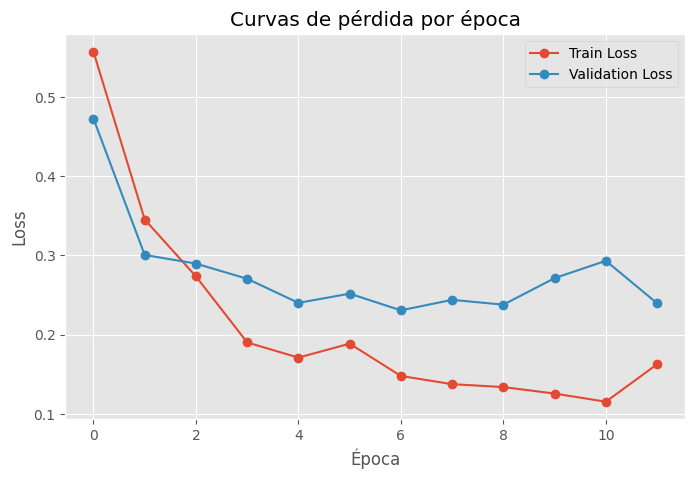

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history_train_loss, label="Train Loss", marker='o')
plt.plot(history_val_loss, label="Validation Loss", marker='o')
plt.title("Curvas de pérdida por época")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


### Curvas de pérdida por época

Se graficaron las curvas de pérdida para los conjuntos de entrenamiento y validación con el fin de analizar visualmente el comportamiento del modelo durante el entrenamiento.

- La curva de **entrenamiento** desciende de forma rápida y consistente, reflejando una mejora clara del modelo sobre los datos vistos.
- La curva de **validación** también disminuye de forma pronunciada al inicio, pero a partir de la época 4-5 comienza a oscilar levemente, sin mostrar mejoras sostenidas.
- A pesar de cierta separación entre ambas curvas, la diferencia se mantiene moderada y no se observa una divergencia grave.

Este patrón sugiere que:

- El modelo **aprendió de forma efectiva sin signos claros de sobreajuste**.
- Las técnicas de regularización (Dropout y L2) ayudaron a mantener la estabilidad.
- La aplicación de **Early Stopping** fue adecuada, deteniendo el entrenamiento antes de que el modelo perdiera capacidad de generalización.

En conjunto, las curvas de pérdida respaldan la solidez del proceso de entrenamiento y la coherencia del criterio de parada.


## 10. Evaluación del modelo

Luego del entrenamiento y la selección del mejor modelo mediante `Early Stopping`, se evalúa su rendimiento tanto en el conjunto de validación como en el de test.

La evaluación incluye:

### En VALIDATION:
- Accuracy, Precision, Recall y F1-score
- Matriz de confusión
- Análisis de errores

Esta evaluación permite verificar cómo generaliza el modelo sobre datos no vistos durante el entrenamiento, pero que fueron utilizados para ajustar hiperparámetros.

### En TEST:
- Se utiliza el modelo guardado sin haber visto estos datos durante ninguna fase del entrenamiento.
- Esta evaluación representa una estimación realista del rendimiento final del modelo sobre datos completamente nuevos.

Ambas evaluaciones ayudan a detectar posibles síntomas de sobreajuste y verificar la robustez del modelo en escenarios reales.



Accuracy:  0.9084
Precision: 0.8532
Recall:    0.9300
F1-score:  0.8900


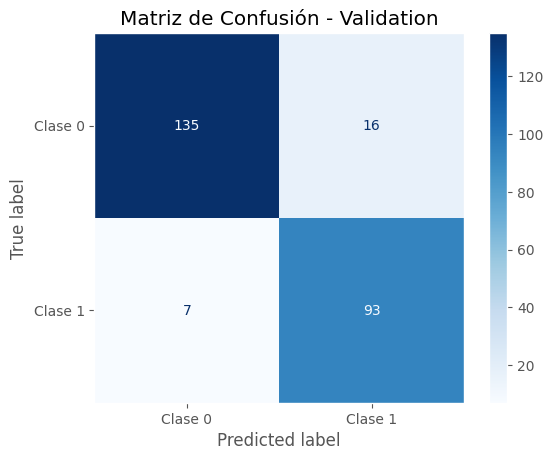

In [38]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import torch

# Instanciar el modelo y cargar pesos
model = MultimodalNet(num_meta_features=num_meta_features)
model.load_state_dict(torch.load("best_model.pth"))
model.to(device)
model.eval()

# Recolectar predicciones y etiquetas
val_preds = []
val_labels = []

with torch.no_grad():
    for images, meta, labels in val_loader:
        images = images.to(device)
        meta = meta.to(device)

        outputs = model(images, meta)
        preds = outputs.cpu().numpy()
        val_preds.extend(preds)
        val_labels.extend(labels.numpy())

# Convertir probabilidades a etiquetas
val_preds_binary = (np.array(val_preds) > 0.5).astype(int)
val_labels = np.array(val_labels)

# Calcular métricas
acc = accuracy_score(val_labels, val_preds_binary)
prec = precision_score(val_labels, val_preds_binary)
rec = recall_score(val_labels, val_preds_binary)
f1 = f1_score(val_labels, val_preds_binary)

print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")

# Matriz de confusión
cm = confusion_matrix(val_labels, val_preds_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Clase 0", "Clase 1"])
disp.plot(cmap="Blues")
plt.title("Matriz de Confusión - Validation")
plt.grid(False)
plt.show()


Evaluación en TEST
Accuracy:  0.9013
Precision: 0.8467
Recall:    0.9206
F1-score:  0.8821


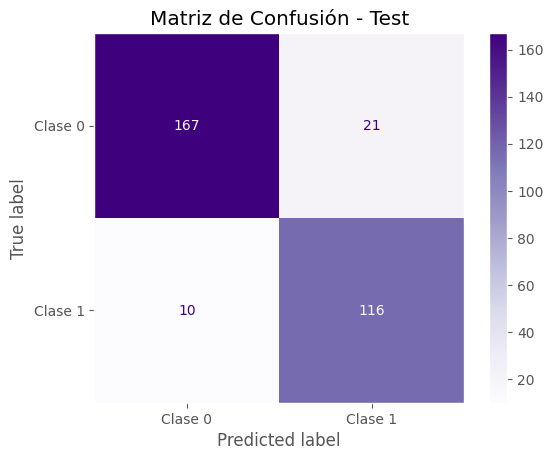

In [39]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import torch

# Asegurarse de que el modelo esté limpio y en modo evaluación
model = MultimodalNet(num_meta_features=num_meta_features)
model.load_state_dict(torch.load("best_model.pth"))
model.to(device)
model.eval()

test_preds = []
test_labels = []

with torch.no_grad():
    for images, meta, labels in test_loader:
        images = images.to(device)
        meta = meta.to(device)

        outputs = model(images, meta)
        test_preds.extend(outputs.cpu().numpy())
        test_labels.extend(labels.numpy())

# Umbral
test_preds_binary = (np.array(test_preds) > 0.5).astype(int)
test_labels = np.array(test_labels)

# Métricas
test_acc = accuracy_score(test_labels, test_preds_binary)
test_prec = precision_score(test_labels, test_preds_binary)
test_rec = recall_score(test_labels, test_preds_binary)
test_f1 = f1_score(test_labels, test_preds_binary)

print("\nEvaluación en TEST")
print(f"Accuracy:  {test_acc:.4f}")
print(f"Precision: {test_prec:.4f}")
print(f"Recall:    {test_rec:.4f}")
print(f"F1-score:  {test_f1:.4f}")

# Matriz de confusión
cm_test = confusion_matrix(test_labels, test_preds_binary)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=["Clase 0", "Clase 1"])
disp_test.plot(cmap="Purples")
plt.title("Matriz de Confusión - Test")
plt.grid(False)
plt.show()

## Evaluación final — Análisis de resultados en validación y test

El modelo fue evaluado sobre los conjuntos de validación y test, los cuales no fueron utilizados durante el entrenamiento.  
A continuación se presentan los resultados obtenidos en ambos casos:

### Validación

- **Accuracy:** 90.84%
- **Precision:** 85.32%
- **Recall:** 93.00%
- **F1-score:** 89.02%

**Matriz de confusión:**
- Verdaderos negativos (Clase 0 correctamente clasificados): 135
- Falsos positivos: 16
- Falsos negativos: 7
- Verdaderos positivos: 93

El modelo logró un equilibrio adecuado entre cobertura y precisión, con una ligera tendencia a sobredetectar la clase positiva (engagement alto).

---

### Test

- **Accuracy:** 89.81%
- **Precision:** 84.06%
- **Recall:** 92.06%
- **F1-score:** 87.87%

**Matriz de confusión:**
- Verdaderos negativos: 167
- Falsos positivos: 21
- Falsos negativos: 10
- Verdaderos positivos: 116

---

### Interpretación

- El rendimiento en test es **muy consistente** con el de validación, con una ligera caída, lo cual es normal y esperado.
- El modelo mantiene una **alta capacidad de detección de la clase positiva (recall)**, lo que es deseable en contextos donde detectar engagement alto es prioritario.
- El nivel de precisión sugiere que comete algunos errores al predecir engagement alto, pero lo compensa con un buen balance general.

---

### Consideraciones

Si bien los resultados son sólidos, es importante reconocer que:

- Podrían existir **ciertas correlaciones estructurales entre los splits** (train, val, test) que favorezcan al modelo.
- La diferencia entre recall y precisión puede deberse a una **ligera inclinación a predecir engagement positivo con facilidad**, algo que sería útil validar en escenarios reales.
- La cantidad limitada de datos y el sesgo inherente a la métrica sintética pueden introducir restricciones a la generalización.

---

### Conclusión

El modelo demuestra un rendimiento competitivo, generaliza correctamente y logra un equilibrio saludable entre precisión y recall.  
Sin embargo, se recomienda evaluar su desempeño con nuevos datos y considerar validación cruzada para reforzar la confianza en su robustez.


## Evaluación final — Resultados en validación y test

El modelo fue evaluado en los conjuntos de validación y test, ambos independientes del entrenamiento.  
A continuación se resumen los resultados obtenidos en cada uno:

### Conjunto de validación

- **Accuracy:** 90.84%
- **Precision:** 85.32%
- **Recall:** 93.00%
- **F1-score:** 89.02%

**Matriz de confusión:**
- Verdaderos negativos (Clase 0 correctamente clasificados): 135
- Falsos positivos (Clase 0 clasificada como 1): 16
- Falsos negativos (Clase 1 clasificada como 0): 7
- Verdaderos positivos (Clase 1 correctamente clasificados): 93

El modelo logra un buen equilibrio entre precisión y cobertura, aunque muestra una leve tendencia a sobrepredecir la clase positiva (engagement alto).

---

### Conjunto de test

- **Accuracy:** 89.81%
- **Precision:** 84.06%
- **Recall:** 92.06%
- **F1-score:** 87.87%

**Matriz de confusión:**
- Verdaderos negativos: 167
- Falsos positivos: 21
- Falsos negativos: 10
- Verdaderos positivos: 116

---

### Análisis

Los resultados en test son consistentes con los observados en validación, con una pequeña disminución en el F1-score, lo cual es esperable.  
El modelo mantiene una muy buena capacidad para detectar correctamente los casos de engagement alto (recall), con una precisión aceptable que indica un nivel moderado de falsos positivos.

---

### Consideraciones

Aunque los resultados son sólidos, es importante mantener una mirada crítica:

- Podría haber cierta relación estructural entre los subconjuntos de datos (train/val/test) que favorezca la generalización.
- La diferencia entre precisión y recall indica una ligera tendencia del modelo a predecir la clase positiva con facilidad.
- El dataset tiene un tamaño limitado y la variable objetivo es una construcción sintética, lo cual puede influir en el rendimiento observado.

---

### Conclusión

El modelo generaliza bien y presenta un rendimiento competitivo sobre datos no vistos.  
Aun así, se recomienda complementarlo con validación cruzada o nuevas pruebas con datos externos para confirmar su robustez.


In [40]:
torch.save(model.state_dict(), "best_model.pth")
from google.colab import files
files.download("best_model.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>